## Purpose
Today we're reviewing K-Means clustering and the many variants. Clustering is a form of 
unsupervised learning, that is quite intuitive and useful (in certain circumstances). 


## What is Cluster Analysis?
First, cluster analysis is a set of methodologies that are utilized to group data by *similarity*.
This can be utilized as a standalone unsupervised model, as an analytical tool, or as form of
feature reduction. 

An example to build intuition is as follows. Say we have a dataset containing 1,000 companies and
associated attributes for those companies, such as employee count, annual expenses, annual 
revenue. With those 2 attributes, visualize a 2D scatter plot. 

You may see some companies, in the lower left hand corner, 
with low revenue and low expenses. Or another group
of companies in another corner with low expenses and high revenue. The more you
look, the more natural groupings you'll be able to visually identify. You may be able to even 
manually group the companies based on those three features, which is awesome, and the goal of 
clustering!

But what happens if we have more attributes? Like employee count, average customer rating, product
count, sales volume, etc... It now gets much harder to visualize, and much harder to logically
group companies, taking into account a multitude of attributes. This is an area where clustering
algorithms come in handy.

## What is K-Means?
So what is K-Means cluster analysis? It's a pretty simple algorithm that works as follows:
1. The user selects the hyper-parameter value for *k*. and the number of iterations n.
2. For each iteration n:
    1. For each observation obs:
       1. Find distance obs is from each centroid.
       2. Assign obs to nearest centroid.
   2. Move each centroid k to the mean of the observations assigned to it's  respective cluster.

## Variations and Hyper-Parameters
There are really 3 things you can change in the K-Means algorithm. 
1. The value of k, which allows you to dictate the number of clusters to be formed.
2. The calculation used for measuring distance. Standard wood be Euclidean distance, but Manhattan
distance among others could also be used.
3. The statistic used for moving the centroid can also be changed. Rather than K-Means, we could
calculate K-Median, for instance. 


## Limitations

From my perspective, there are several major limitations to using K-Means clustering. The 
required data assumptions, how new data is handled, and the selection of k. 

First, when utilizing K-Means, you have to assume the data is distributed in a spherical manner. 
Otherwise, the clusters will likely not be very logical when analyzed. A straightforward illustration
of this, is showing results of K-Means on 2D, non spherical data. You can visually see that the 
resulting clusters do not make sense.

Another limitation, is how it handles new data. The number of clusters, k, is set. So, if a month
after a deployment, a seemingly new cluster forms some where in the data space, that in the case of
2d data, could easily be visually identified. It doesn't matter, it will still be assigned to 
one of the original k-clusters. Other clustering algorithms hae *noise* components that can better
adapt and handle unseen data distributions in my opinion.

Finally, I find the the selection of *k* to be boarding more art than science. We have the *elbow
test* and other similar metrics to guide us in our selection, but at the end of the day the selection
of k is at the discretion of the data scientist. Which is unsettling to me.

## Example
For the example, we're going to read in a table wtih
three columns: gender, height, and weight. For now, we're
going to ignore gender, and just look at height and weight.

The first step, as always, is to import relevant libraries.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


Now we read in our data into a Pandas dataframe.

In [10]:

iris = datasets.load_iris()
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
X = data[["petal length (cm)", "petal width (cm)"]].values
data.sample(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
12,4.8,3.0,1.4,0.1,0.0
3,4.6,3.1,1.5,0.2,0.0
82,5.8,2.7,3.9,1.2,1.0
6,4.6,3.4,1.4,0.3,0.0
113,5.7,2.5,5.0,2.0,2.0
119,6.0,2.2,5.0,1.5,2.0
54,6.5,2.8,4.6,1.5,1.0
78,6.0,2.9,4.5,1.5,1.0
29,4.7,3.2,1.6,0.2,0.0
131,7.9,3.8,6.4,2.0,2.0


Here we're defining our distant measure. We're going to use the standard Euclidean distance
(L2-Norm).

$$ L2\ Normalization = \sum\sqrt{(a_i-b_i)^2}  = ||\vec{a} - \vec{b}||_2$$

In [11]:
def euclidean_norm(a, b,centers=False):
    a = np.array(a)
    b = np.array(b)
    axis = 1
    if centers == True:
        axis=0
    return np.sqrt(np.sum((a - b)**2, axis=axis))

Now we build our k_means model object.  It has two parameters we haven't discussed yet; tol
and seed. tol is a threshold for how much the centroids are moving from iteration to iteration.
If a the centroids are stable no longer moving, than we can stop early. 

seed is a common parameter name for random generators. If you set the seed, then you can re-produce
results, even when stochastic processes are involved. In this case, the stochastic process is
the initialization of the centroids.

In [12]:
class k_means:
    def __init__(self, k=3, tol=10e-4, iters=10, seed=None):
        self.k = k
        self.centroids = []
        self.k = k
        self.tol = tol
        self.iters = iters
        self.seed = seed
        
    def fit(self, X):
        # initialize clusters
        if self.seed != None:
            np.random.seed(self.seed)

        temp = X.copy()
        for i in range(0,self.k):
            init_k = np.random.randint(len(temp))
            self.centroids.append(X[init_k])
            temp=np.delete(temp, init_k, 0)
        # Iterate through
        for j in range(0,self.iters):

            # distance to each centroid.
            dists_to_centroids = np.zeros((len(X), len(self.centroids)))
            for k in range(len(self.centroids)):
                for i in range(len(X)):
                   dists_to_centroids[i,k] = euclidean_norm(X[i], self.centroids[k],centers=True)
                    
            # Assign observation to nearest centroid
            cluster_assignment = np.argsort(dists_to_centroids)[:,0]

            # Set Centroid location to be mean of observations assigned to it 
            new_centers = np.zeros((self.k,X.shape[1]))
            for k in range(self.k):
                obs_in_cluster = X[cluster_assignment==k]
                if len(obs_in_cluster) > 0:
                    new_centers[k] = np.mean(obs_in_cluster,axis=0)
                else:
                    new_centers[k] = self.centroids[k]

            self.centroids = new_centers

                                


    def predict(self,X):
        # Calculate distances
        dists = []
        for centroid in self.centroids:    
            dists.append(euclidean_norm(centroid,X))
        dists = np.array(dists).T
        # Assign Clusters
        cluster = []
        
        for i in range(0,len(dists)):
            cluster.append(dists[i].argmin())

        return np.array(cluster)

Now that we have the k_means object, we instantiate it, and fit it to our data.

In [13]:
algo = k_means(3,iters=100,seed=2)
algo.fit(X)

Once our model is trained, let's check where the centroids are.

Text(0, 0.5, 'petal width (cm)')

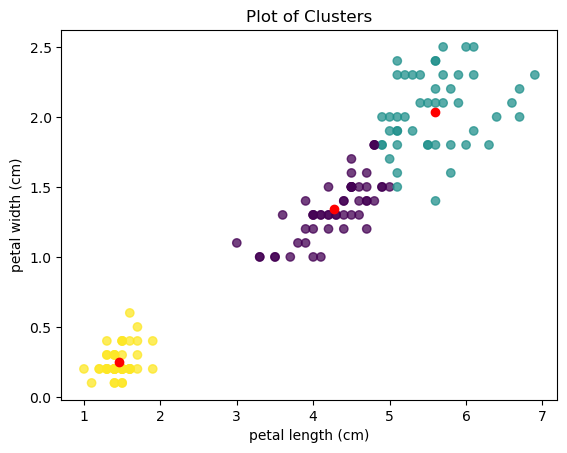

In [14]:
plt.scatter(X[:,0],X[:,1],c=algo.predict(X),alpha=0.75)
plt.scatter(algo.centroids[:,0], algo.centroids[:,1],c="red")
plt.title("Plot of Clusters")
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")

## Metrics
First, let's talk about the **Silhouette Coefficient (SC)**. The takes into
account both cohesion and separation. Cohesion is a measure of how similar
 the observations within a cluster are too each other. Separation is looking
at how similar the observations of a cluster are with other clusters.
Inertia
Distance & Similarity

- a :=intra-cluster disances
- b := nearest-cluster distances
- SC := Silhouette Coefficient
- K := Number of clusers
- k2 := Nearest Cluster
- $N^k$ := Number of samples in cluster k
- $X^k$ := Subset of X observations in cluster k
- $C_k$ := Cluster k
- $C_{k2}$ := Nearest cluster k





To calculate $a$, we take the euclidean between observation $X_i$ and every other observation, $X_j$ assigned to the same cluster. We then average it.

$$a_i = \frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{N^k} \sum_{j=2}^{N^k}[||X_i - X_j||_2 $$

To calculate $b$, we do the same thing, but instead of the mean euclidean distance between an observation and other observations within its assigned cluster, we get the distances to observations in its closest neighboring cluster, $k2$.

$$b_i = \frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{N^k} \sum_{j=2}^{N^{k2}}[||X_i - X_j||_2 $$

$$SC = \sum_i^N \frac{b_i - a_i}{max(b_i,a_i)}$$

Now lets implement it. Below we create a function for calculating a silhouette coefficient, given a trained model and data.

In [15]:
def silhouette_coefficient(data,model):
    # Assign data to cluster
    X = data.copy()
    y = model.predict(X)

    # Cluster Distances
    """
    this loop calculates distance of each observation to each centroid. This is used to determine k and k2 for each element.
    """
    dists_to_centroids = np.zeros((len(X), len(model.centroids)))
    for k1 in range(len(model.centroids)):
        for i in range(len(X)):
           dists_to_centroids[i,k1] = euclidean_norm(X[i], model.centroids[k1],centers=True)

    # Mean Intra-Cluser Distances
    """
    This loop calculates the mean distance of each observation, with all other observations within the same cluster
    """
    a = np.zeros((len(X)))
    for i in range(len(X)):
        k = np.argsort(dists_to_centroids[i])[0]
        a[i] = np.mean(euclidean_norm(X[i],X[y==k]))

    # Mean nearest-Cluster Distance
    """
    This loop calculates the mean distance of each obersation, with all other observations in the cluster nearest to it.
    """
    b = np.zeros((len(X)))
    for i in range(len(X)):
        k = np.argsort(dists_to_centroids[i])[1]
        b[i] = np.mean(euclidean_norm(X[i],X[y==k]))


    s = np.zeros((len(X)))
    for i in range(len(X)):
        top = b[i]-a[i]
        bot = np.max([a[i],b[i]])
                     
        s = np.sum(top/bot)
    
    return s

Great! now let's see what the silhouette coefficient is for our model.

In [16]:
silhouette_coefficient(X,algo)

0.3101181760265349

Our silhouette coefficient is ~0.31, which isn't great. How can we try to improve this? Well, without applying transforms to the data, we really have two options.

Option 1 is to re-train the model with a different random seed. This doesn't sound like a big change, but in practice, a different initialization of your centroids can have major impact on the model.

Option 2 is to change the value k. How do you select how many clusters there shuold be? Unfortunately there is no easy answer to this, and why cluster analysis can sometimes seem more like an art than a science. The most common tool used to select k, is called the "elbow test." T

The elbow test involves iterating through multiple values of k, and taking the *interia* each time. Than plotting the inertia, and finding the joint in the graph. It's usually a good bet that the value k where the joint is located is close to the optimal value k.

So what is inertia? Inertia in this sense really calculating is the Within-Cluster Sum of Squares (WCSS). 
$$WCSS= \frac{1}{K} \sum_k^K \frac{||X_k - C_k||_2}{N^k}$$

That is to say, taking the average distance between an onbservation in cluster k, and the centroid k for each centroid, and then taking the mean value of the 3 centroid WCSS calcuations.


Below we are going to create two functions. The first will calculate the inertia for a given trained model and a set of data. The second function will train a model multiple times on a range of k values, and return two lists, one containing the k values, and other contianing there respective average inertia.

In [17]:
def inertia(data,model):
    # Assign data to cluster
    X = data.copy()
    y = model.predict(X)
    # distance to each centroid.
    dist_to_centroid = np.zeros((len(X)))

    for k in range(model.k):
        dist_to_centroid[y==k] = euclidean_norm(X[y==k], model.centroids[k])
    inertias=np.zeros(model.k)
    for k in range(model.k):
        inertias[k] = np.sum(dist_to_centroid[y==k] / len(X[y==k]))
       
        
    return np.mean(inertias)

In [18]:
def elbow_test(data,k):
    inertias=[]
    ks = []
    for k in range(2,k):
        tests = []
        for j in range(1,4):
            algo = k_means(k,iters=20,seed=10)
            algo.fit(data)
            tests.append(inertia(data,algo))
        inertias.append(np.mean(tests))
        ks.append(k)
    return ks, inertias


Let's utilize the above two functions to plot our elbow graph.

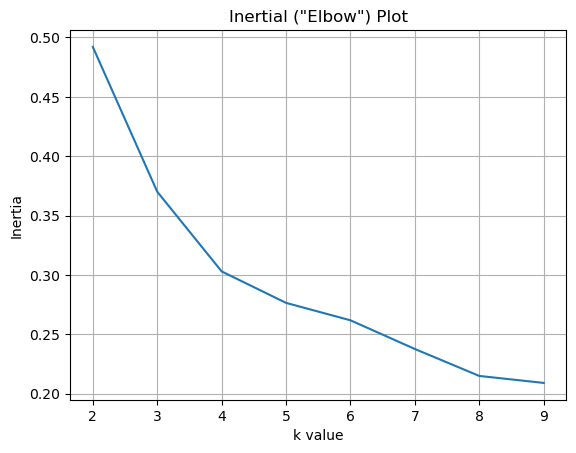

In [19]:
ks, inertias = elbow_test(X,k=10)
plt.plot(ks,inertias)
plt.title('Inertial ("Elbow") Plot')
plt.xlabel("k value")
plt.ylabel("Inertia")
plt.grid(True)

Looking at the above graph, it looks like the joint is at 4. Let's try re-training the model with k=4 and see how that impacts our silhouette coefficient.

In [20]:
algo = k_means(4,iters=100,seed=2)
algo.fit(X)
silhouette_coefficient(X,algo)

0.3101181760265349

Text(0, 0.5, 'petal width (cm)')

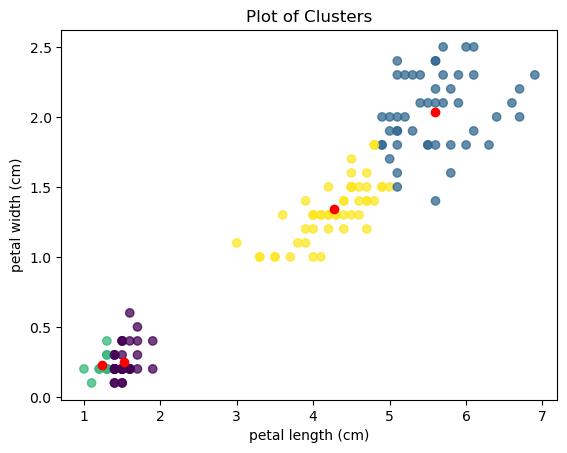

In [21]:
plt.scatter(X[:,0],X[:,1],c=algo.predict(X),alpha=0.75)
plt.scatter(algo.centroids[:,0], algo.centroids[:,1],c="red")
plt.title("Plot of Clusters")
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")

Yikes! That is definitely not better than our last model. What happened? Well remember the elbow chart takes into account the average of mulitple different initializations. And it looks like two of the clusters in the bottom left got initialized too close together. Let's try a different intializaiton and see what happens.

In [22]:
algo = k_means(4,iters=100,seed=4)
algo.fit(X)
silhouette_coefficient(X,algo)

0.6719573190314571

0.67 is a much better score! Below is the plot of the clusters now that they've been reinitialized.

Text(0, 0.5, 'petal width (cm)')

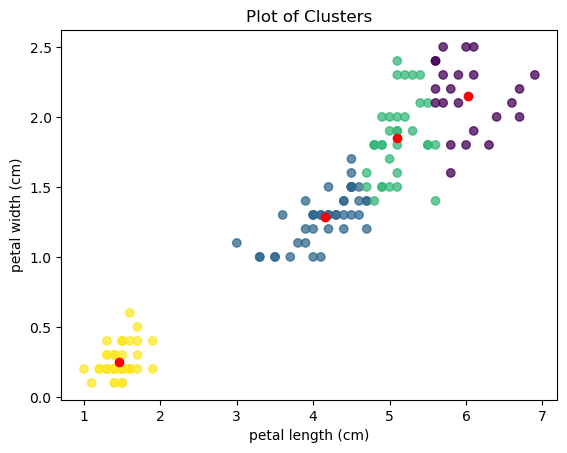

In [23]:
plt.scatter(X[:,0],X[:,1],c=algo.predict(X),alpha=0.75)
plt.scatter(algo.centroids[:,0], algo.centroids[:,1],c="red")
plt.title("Plot of Clusters")
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")

Something important of note, is that the dataset used in this example is actually labelled - and there are 3  classes! So ideally, K-means would have found 3 different clusters, one representing each class. That did not happen, likely due to several reasons, a couple being:

- We only used 2 of the 3 dimensions in this example. The 3rd dimension may have provided further separation between the two overlapping clusters.
- K-means requires that the clusters be spherical in nature. It looks like 2 of the clusters are more elongated than spherical.



## conclusion

In todays post we:

- Reviewed the K-Means Algorithm
- Implemented the K-Means Algorithm
- Reviewed the math and then implemented code for the silhouette coefficient
- Reviewed the math and then implemented the code for WCSS calculations
- Discussed the "elbow curve"

As always please provide feedback and let me know if you spot anything amiss with the content of this blog post; or let me know if you found it useful!

Thanks for reading!